In [17]:
# --- 1. Setup and Imports ---
import pandas as pd
import numpy as np
import time
import random
import os
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, average_precision_score, accuracy_score
from sklearn.preprocessing import label_binarize

from nltk.sentiment.vader import SentimentIntensityAnalyzer
from textblob import TextBlob
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\lingyi\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [18]:
# --- 2. Load 1000 Labeled Evaluation Data ---
print("Loading manually labeled 1000-row dataset...")
base_path = os.path.abspath(os.path.join(os.getcwd(), '..'))
data_path = os.path.join(base_path, "data")

# Load labeled polarity & subjectivity
polarity_file = os.path.join(data_path, "1000_GT_polarity_labels.csv")
subjectivity_file = os.path.join(data_path, "1000_GT_subj_labels.csv")

df_polarity = pd.read_csv(polarity_file)
df_subjectivity = pd.read_csv(subjectivity_file)

# Clean column names
pol_cols = [col.strip().replace(" ", "_").replace(".", "") for col in df_polarity.columns]
subj_cols = [col.strip().replace(" ", "_").replace(".", "") for col in df_subjectivity.columns]
df_polarity.columns = pol_cols
df_subjectivity.columns = subj_cols

# Merge both by cleaned_text
df_eval = pd.merge(
    df_polarity[["cleaned_text", "GT_Polarity_Label"]],
    df_subjectivity[["cleaned_text", "GT_Subjective_Label"]],
    on="cleaned_text", how="inner"
)
print(f"Evaluation dataset ready: {df_eval.shape[0]} rows")


Loading manually labeled 1000-row dataset...
Evaluation dataset ready: 1092 rows


In [19]:
# --- Performance Benchmarking for Q4f ---
print("\n=== Training Time and Inference Benchmarks ===")
benchmark_results = []


=== Training Time and Inference Benchmarks ===


In [20]:
# --- 3. Subjectivity Classification (Random Forest & Naive Bayes) ---
print("\n=== Subjectivity Classification ===")
X_subj = df_eval["cleaned_text"]
y_subj = df_eval["GT_Subjective_Label"]
X_train_subj, X_test_subj, y_train_subj, y_test_subj = train_test_split(X_subj, y_subj, test_size=0.2, random_state=42)

# Random Forest Subjectivity
pipeline_subj_rf = Pipeline([
    ('vectorizer', CountVectorizer()),
    ('clf', RandomForestClassifier(random_state=42))
])
t0 = time.time()
pipeline_subj_rf.fit(X_train_subj, y_train_subj)
t1 = time.time()
y_pred_subj_rf = pipeline_subj_rf.predict(X_test_subj)
t2 = time.time()
benchmark_results.append(["Random Forest (Subjective)", round(t1 - t0, 2), round(t2 - t1, 2), accuracy_score(y_test_subj, y_pred_subj_rf)])

print("Random Forest Subjectivity Report:")
print(classification_report(y_test_subj, y_pred_subj_rf, target_names=["Objective", "Subjective"]))

# Naive Bayes Subjectivity
pipeline_subj_nb = Pipeline([
    ('vectorizer', CountVectorizer()),
    ('clf', MultinomialNB())
])
t0 = time.time()
pipeline_subj_nb.fit(X_train_subj, y_train_subj)
t1 = time.time()
y_pred_subj_nb = pipeline_subj_nb.predict(X_test_subj)
t2 = time.time()
benchmark_results.append(["Naive Bayes (Subjective)", round(t1 - t0, 2), round(t2 - t1, 2), accuracy_score(y_test_subj, y_pred_subj_nb)])

print("Naive Bayes Subjectivity Report:")
print(classification_report(y_test_subj, y_pred_subj_nb, target_names=["Objective", "Subjective"]))



=== Subjectivity Classification ===
Random Forest Subjectivity Report:
              precision    recall  f1-score   support

   Objective       0.78      0.37      0.50       102
  Subjective       0.62      0.91      0.74       117

    accuracy                           0.66       219
   macro avg       0.70      0.64      0.62       219
weighted avg       0.69      0.66      0.63       219

Naive Bayes Subjectivity Report:
              precision    recall  f1-score   support

   Objective       0.76      0.38      0.51       102
  Subjective       0.62      0.90      0.74       117

    accuracy                           0.66       219
   macro avg       0.69      0.64      0.62       219
weighted avg       0.69      0.66      0.63       219



In [21]:
# --- 4. Polarity Classification (Random Forest & Naive Bayes) ---
print("\n=== Polarity Classification ===")
X_pol = df_eval["cleaned_text"]
y_pol = df_eval["GT_Polarity_Label"]
X_train_pol, X_test_pol, y_train_pol, y_test_pol = train_test_split(X_pol, y_pol, test_size=0.2, stratify=y_pol, random_state=42)

# Naive Bayes Polarity
pipeline_nb = Pipeline([
    ('vectorizer', CountVectorizer()),
    ('clf', MultinomialNB())
])
t0 = time.time()
pipeline_nb.fit(X_train_pol, y_train_pol)
t1 = time.time()
y_pred_nb = pipeline_nb.predict(X_test_pol)
t2 = time.time()
benchmark_results.append(["Naive Bayes (Polarity)", round(t1 - t0, 2), round(t2 - t1, 2), accuracy_score(y_test_pol, y_pred_nb)])

# Random Forest Polarity
pipeline_rf = Pipeline([
    ('vectorizer', CountVectorizer()),
    ('clf', RandomForestClassifier(random_state=42))
])
t0 = time.time()
pipeline_rf.fit(X_train_pol, y_train_pol)
t1 = time.time()
y_pred_rf = pipeline_rf.predict(X_test_pol)
t2 = time.time()
benchmark_results.append(["Random Forest (Polarity)", round(t1 - t0, 2), round(t2 - t1, 2), accuracy_score(y_test_pol, y_pred_rf)])



=== Polarity Classification ===


In [22]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Create function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='Blues')
    plt.title(title)
    plt.show()


In [27]:
# --- 7. Q5 Innovations & Ablation Study ---
print("\n=== Q5: Innovation Study (NER + ABSA + Ensemble) ===")
# ABSA (on evaluation set): Simulate using 'coin_listings' feature from crypto_exchange_data_preprocessed.csv
absa_path = os.path.join(data_path, "crypto_exchange_data_preprocessed.csv")
df_full = pd.read_csv(absa_path)

# ABSA
print("Performing ABSA on 'coin_listings'...")
df_absa = pd.merge(df_eval, df_full[['cleaned_text', 'coin_listings']], on='cleaned_text', how='left')
df_absa = df_absa.dropna(subset=['coin_listings'])
y_absa = (df_absa['coin_listings'] > 0).astype(int)
X_absa = df_absa['cleaned_text']
X_train_absa, X_test_absa, y_train_absa, y_test_absa = train_test_split(X_absa, y_absa, test_size=0.2, random_state=42)

absa_model = Pipeline([
    ('vectorizer', CountVectorizer()),
    ('clf', RandomForestClassifier(random_state=42))
])
absa_model.fit(X_train_absa, y_train_absa)
y_pred_absa = absa_model.predict(X_test_absa)
absa_score = accuracy_score(y_test_absa, y_pred_absa)
print("ABSA (Coin Listings Sentiment on Eval Set) Classification Report:")
print(classification_report(y_test_absa, y_pred_absa))

# NER-enhanced
print("Performing NER-enhanced classification...")
df_ner = pd.merge(df_eval, df_full[['cleaned_text', 'entities']], on='cleaned_text', how='left')
df_ner = df_ner[df_ner['entities'].apply(lambda x: isinstance(x, str) and len(x) > 2)]
X_ner = df_ner["cleaned_text"]
y_ner = df_ner["GT_Polarity_Label"]
X_train_ner, X_test_ner, y_train_ner, y_test_ner = train_test_split(X_ner, y_ner, test_size=0.2, random_state=42)

ner_model = Pipeline([
    ('vectorizer', CountVectorizer()),
    ('clf', RandomForestClassifier(random_state=42))
])
ner_model.fit(X_train_ner, y_train_ner)
y_pred_ner = ner_model.predict(X_test_ner)
ner_score = accuracy_score(y_test_ner, y_pred_ner)
print("NER-enhanced (on Eval Set) Classification Report:")
print(classification_report(y_test_ner, y_pred_ner))

# Ensemble Voting on base classifiers
print("Performing Ensemble Voting...")
y_pred_vader = X_test_pol.apply(lambda x: SentimentIntensityAnalyzer().polarity_scores(x)["compound"]).apply(
    lambda s: 1 if s > 0.05 else 0 if s < -0.05 else 2)

y_pred_textblob = X_test_pol.apply(lambda x: TextBlob(x).sentiment.polarity).apply(
    lambda p: 1 if p > 0.1 else 0 if p < -0.1 else 2)

# Combine model predictions using majority voting
ensemble_df = pd.DataFrame({
    "rf": list(y_pred_rf),
    "nb": list(y_pred_nb),
    "vader": list(y_pred_vader),
    "blob": list(y_pred_textblob)
})

ensemble_df["ensemble"] = ensemble_df.mode(axis=1)[0]
ensemble_score = accuracy_score(y_test_pol.reset_index(drop=True), ensemble_df["ensemble"])
print(f"Ensemble Voting Accuracy: {ensemble_score:.4f}")
print("Ensemble Voting Classification Report:")
print(classification_report(y_test_pol.reset_index(drop=True), ensemble_df["ensemble"]))


=== Q5: Innovation Study (NER + ABSA + Ensemble) ===
Performing ABSA on 'coin_listings'...
ABSA (Coin Listings Sentiment on Eval Set) Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.99      0.89       167
           1       1.00      1.00      1.00     10844

    accuracy                           1.00     11011
   macro avg       0.90      1.00      0.94     11011
weighted avg       1.00      1.00      1.00     11011

Performing NER-enhanced classification...
NER-enhanced (on Eval Set) Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.86      0.74        58
           1       0.00      0.00      0.00        15
           2       0.50      0.41      0.45        29

    accuracy                           0.61       102
   macro avg       0.38      0.43      0.40       102
weighted avg       0.51      0.61      0.55       102

Performing Ensemble Voting...


d:\lingyi\Documents\4032 data\SC4021---Group-20\venv\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\lingyi\Documents\4032 data\SC4021---Group-20\venv\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\lingyi\Documents\4032 data\SC4021---Group-20\venv\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Ensemble Voting Accuracy: 0.6484
Ensemble Voting Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.93      0.75       105
           1       0.67      0.25      0.36        40
           2       0.69      0.46      0.55        74

    accuracy                           0.65       219
   macro avg       0.66      0.55      0.56       219
weighted avg       0.66      0.65      0.61       219



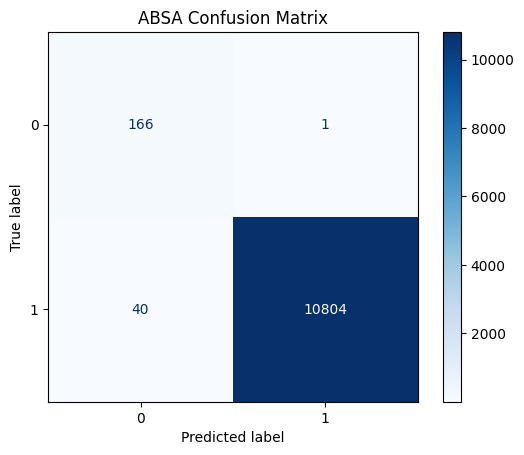

In [24]:
plot_confusion_matrix(y_test_absa, y_pred_absa, title="ABSA Confusion Matrix")

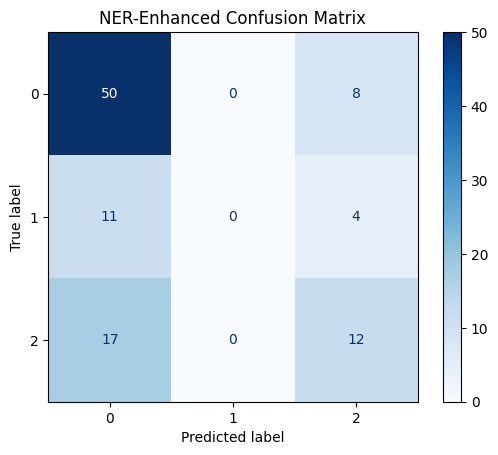

In [25]:
plot_confusion_matrix(y_test_ner, y_pred_ner, title="NER-Enhanced Confusion Matrix")


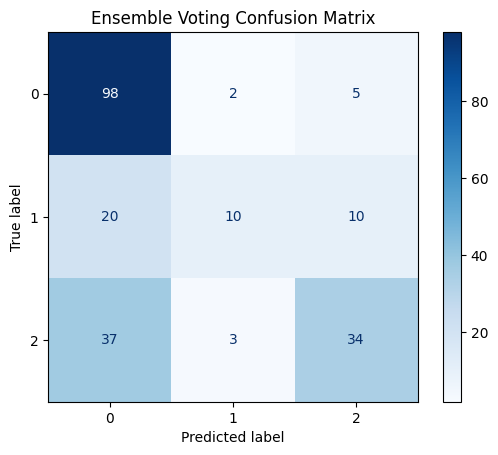

In [26]:
plot_confusion_matrix(y_test_pol.reset_index(drop=True), ensemble_df["ensemble"], title="Ensemble Voting Confusion Matrix")


In [15]:
aspects = ['fees', 'user_interface', 'customer_service', 'security', 'coin_listings', 'performance']
df_full = pd.read_csv(os.path.join(data_path, "crypto_exchange_data_preprocessed.csv"))

for aspect in aspects:
    counts = (df_full[aspect] > 0).value_counts()
    print(f"\n{aspect} distribution:")
    print(counts)



fees distribution:
False    57444
True      7016
Name: fees, dtype: int64

user_interface distribution:
False    47979
True     16481
Name: user_interface, dtype: int64

customer_service distribution:
False    48965
True     15495
Name: customer_service, dtype: int64

security distribution:
False    57917
True      6543
Name: security, dtype: int64

coin_listings distribution:
False    40934
True     23526
Name: coin_listings, dtype: int64

performance distribution:
False    53992
True     10468
Name: performance, dtype: int64



=== Q5 Ablation Summary Table ===
        Model  Accuracy
0     Base RF  0.589041
1      + ABSA  0.996276
2       + NER  0.607843
3  + Ensemble  0.648402


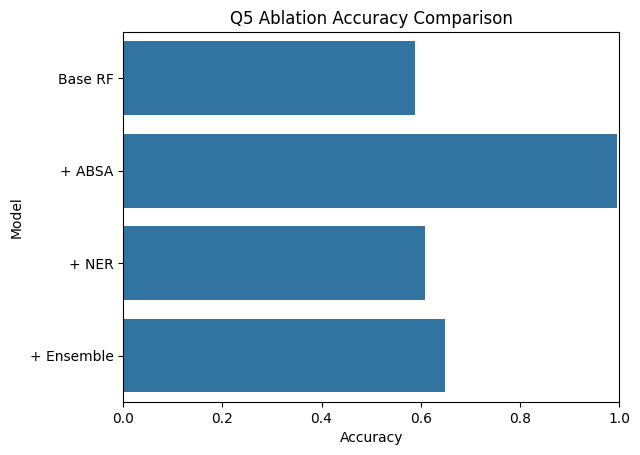

In [16]:
# --- Summary Table ---
print("\n=== Q5 Ablation Summary Table ===")
ablation_results = pd.DataFrame({
    "Model": ["Base RF", "+ ABSA", "+ NER", "+ Ensemble"],
    "Accuracy": [accuracy_score(y_test_pol, y_pred_rf), absa_score, ner_score, ensemble_score]
})
print(ablation_results)

sns.barplot(x="Accuracy", y="Model", data=ablation_results)
plt.title("Q5 Ablation Accuracy Comparison")
plt.xlim(0, 1)
plt.show()
